# Bonus Track: Rendering 



In [1]:
#import modules and libraries
import sys
sys.path.insert(0, "../Environment/")
sys.path.insert(0, "../Modules/")
import halite_env as Env
import encode as cod
import ship 
import rendering

import numpy as np
import matplotlib.pyplot as plt

In [2]:
#@@@@@@@@@@@@@@@@@@@@@@
# Environment variables
#@@@@@@@@@@@@@@@@@@@@@@
NUM_PLAYERS = 1
MAP_SIZE = 7 # 7 x 7 map
TOT_TURNS = 400 # number of turns for each episode

#@@@@@@@@@@@@@@@@
# State variables
#@@@@@@@@@@@@@@@@
MAP_H_THRESHOLDS = np.array([100,500,1000]) # 3 halite levels for the halite in the map's cells
H_LEV = len(MAP_H_THRESHOLDS)
CARGO_THRESHOLDS = np.array([100,500,800,1000]) # 4 halite levels for the halite carried (finer granularity)
CARGO_LEV = len(CARGO_THRESHOLDS)
N_CELLS = MAP_SIZE**2 # number of cells in a square map
N_STATES = N_CELLS*(H_LEV**5)*CARGO_LEV*4
N_ACTIONS = 5 # no dropoffs, 1 action for staying still, 4 for moving in the cardinal directions
print("Total number of states to be experienced: ", N_STATES)

#@@@@@@@@@@@@@@@@@@@@
# Learning parameters
#@@@@@@@@@@@@@@@@@@@@
N_BATCH = 70 # number of episodes in an epoch
MAX_EPOCHS = 200 # max number of epochs played before stopping
DISCOUNT_FACTOR = 1 - 1/TOT_TURNS #train ships as if each turn has a probability of 1/tot_turns of ending the game 
R0 = -0.01 # penalty given each turn to the ship if it doesn't deposit halite in the shipyard ("cost of the time")
R1 = R0*50 # penalty given to the ship when deposits halite ("cost of a loop")
LEARNING_RATE = 0.1
EPS_START = 0.5

Total number of states to be experienced:  190512


In [3]:
# convert all the parameters to dictionaries
env_dict = dict(NUM_PLAYERS = NUM_PLAYERS , 
                TOT_TURNS = TOT_TURNS)

state_dict = dict(MAP_SIZE = MAP_SIZE,  
                  MAP_H_THRESHOLDS = MAP_H_THRESHOLDS, 
                  CARGO_THRESHOLDS = CARGO_THRESHOLDS,
                  N_ACTIONS = N_ACTIONS)

learning_dict = dict(LEARNING_RATE = LEARNING_RATE, 
                     DISCOUNT_FACTOR = DISCOUNT_FACTOR , 
                     eps = EPS_START, 
                     R0 = R0, R1 = R1)

In [4]:
q_values = np.load("Q_values/Q_values_new_method.npy")

In [5]:
from importlib import reload
reload(rendering)

<module 'rendering' from '../Modules/rendering.py'>

<IPython.core.display.Javascript object>


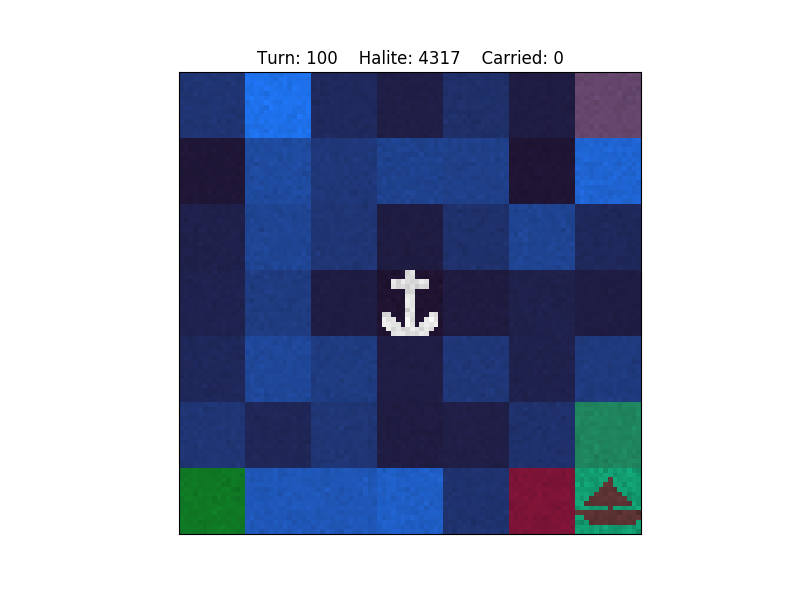

In [6]:
import time

save = False
debug = False
verbose = False
eps = 0.05

%matplotlib notebook

fig = plt.figure(figsize = (8,6))

# define some derived constants
H_LEV = len(MAP_H_THRESHOLDS)
CARGO_LEV = len(CARGO_THRESHOLDS)

verbose_print = print if verbose else lambda *args, **kwargs : None # define verbose printing function

env = Env.HaliteEnv(NUM_PLAYERS, MAP_SIZE, episode_lenght = 100) # init environment
steps = 0
reward = 0 # cumulative reward of the episode
passages = 0 # number of times the ship passes through the shipyard

# first mandatory step
steps = steps + 1
verbose_print("\nStep number %d:"%steps)
action_matrix = np.full((MAP_SIZE,MAP_SIZE), -1) # no ship, no action
shipyard_action = True # initially always choose to create a ship
# returns the matricial state, the array of players halite and a flag that is true if it's the final turn
state, players_halite, finish, _ = env.step(action_matrix, makeship = shipyard_action) 
current_halite = players_halite[0][0]
#----------------------------------------------------------
rgb_map = rendering.color_sea(state[:,:,0]) # get rgb map of blue tonalities
up_map = rendering.upscale_colormap(rgb_map, 14)
up_map = rendering.insert_shipy(up_map)
plt.imshow(up_map) # show map
plt.title("Turn: %d    Halite: %d"%(steps,current_halite))
plt.yticks([])
plt.xticks([])
fig.show()
fig.canvas.draw() # update the figure
#time.sleep(2) #uncomment to slow down for visualization purposes
if save:
    plt.savefig('.raw_gif_HQ/turn%.3d.png'%steps)
#-----------------------------------------------------------
s_enc = cod.encode_state_v1(state, MAP_H_THRESHOLDS, CARGO_THRESHOLDS, map_size = MAP_SIZE, debug = debug)


while True:
    steps = steps + 1
    verbose_print("\nStep number %d:"%steps)
    verbose_print("Current halite: ", current_halite)
    a_enc = ship.e_greedy_policy(s_enc, q_values, eps = eps)
    a_mat = cod.scalar_to_matrix_action(a_enc, state, map_size = MAP_SIZE) #convert the action in matricial form
    s_dec = cod.decode3D(s_enc, L1 = MAP_SIZE**2, L2 = CARGO_LEV*H_LEV**5, L3 = N_ACTIONS-1)
    x,y = cod.decode(s_dec[0], L=MAP_SIZE) # position of the ship, used in rendering
    ship_cargo = state[x,y,2] # halite in the ship, used in rendering
    # submit the action and get the new state
    state, players_halite, finish, _ = env.step(a_mat, makeship = False) 

    new_halite = players_halite[0][0]

    # compute the 1-ship reward as the halite increment of the player divided by the max halite 
    # plus a standard negative reward 
    #---------------------------------------------------------------------------------------------------------
    if new_halite == current_halite:
        r =  R0
    else:
        r = (new_halite - current_halite)/1000 + R1 # this is the change in the code
    #---------------------------------------------------------------------------------------------------------
    sp_enc = cod.encode_state_v1(state, MAP_H_THRESHOLDS, CARGO_THRESHOLDS, map_size = MAP_SIZE, debug = debug)
    reward += r # cumulative reward of the episode

    # adds 1 to passages if the current position of the ship coincides with that of the shipyard
    # whereas the previous position didn't
    
    sp_dec = cod.decode3D(sp_enc, L1 = MAP_SIZE**2, L2 = CARGO_LEV*H_LEV**5, L3 = N_ACTIONS-1)
    shipy_pos = (MAP_SIZE**2-1)/2 #shipyard is at the center of the map
    if (sp_dec[0] == shipy_pos and s_dec[0] != shipy_pos):
        passages = passages +1

    a_temp_enc = ship.greedy_policy(sp_enc, q_values) # simulate the best action in the new state (before update)

    #----------------------------------------------------------
    rgb_map = rendering.color_sea(state[:,:,0]) # get rgb map of blue tonalities
    color = rendering.color_ship(ship_cargo) # superimpose the ship pixel with a yellow tonality
    up_map = rendering.upscale_colormap(rgb_map)
    up_map = rendering.insert_shipy(up_map)
    up_map = rendering.insert_ship(up_map, color, x, y)
    
    plt.cla() # clear current axis from previous drawings -> prevents matplotlib from slowing down
    plt.imshow(up_map)
    plt.title("Turn: %d    Halite: %d    Carried: %d"%(steps,current_halite-4000,ship_cargo))
    plt.yticks([]) # remove y ticks
    plt.xticks([]) # remove x ticks
    fig.canvas.draw() # update the figure
    #time.sleep(2) #uncomment to slow down for visualization purposes
    if save:
        plt.savefig('.raw_gif_HQ/turn%.3d.png'%(steps*2))
    # shows Q-values projected on the cells adjacent to the ship
    rgb_map = rendering.decision_map(q_values[s_enc], x, y, rgb_map, MAP_SIZE) 
    up_map = rendering.upscale_colormap(rgb_map)
    up_map = rendering.insert_shipy(up_map)
    up_map = rendering.insert_ship(up_map, color, x, y)
    plt.imshow(up_map)
    #move_dict = {0:'C',1:'S',2:'N',3:'E',4:'W'}
    plt.title("Turn: %d    Halite: %d    Carried: %d"%(steps, current_halite-4000, ship_cargo))
    #+"Next action: "+move_dict[a_enc]) # to print also what the next move will be
    plt.yticks([]) # remove y ticks
    plt.xticks([]) # remove x ticks
    fig.canvas.draw() # update the figure
    #time.sleep(2) #uncomment to slow down for visualization purposes
    if save:
        plt.savefig('.raw_gif_HQ/turn%.3d.png'%(steps*2+1))
    #-----------------------------------------------------------
    
    # update Q-values
    q_values = ship.update_q_v3(s_enc, a_enc, r, sp_enc, a_temp_enc, q_values, 
                                alpha = LEARNING_RATE, gamma = DISCOUNT_FACTOR, map_size = MAP_SIZE, 
                                h_lev = H_LEV, cargo_lev = CARGO_LEV, n_actions = N_ACTIONS)

    # update states and halite
    s_enc = sp_enc
    current_halite = new_halite

    if (finish == True) or (steps >= 400):
        verbose_print("\nEnd episode.")
        break

In [ ]:
import os
filenames = os.listdir('.raw_gif_HQ') # get the names of all the files in .raw_gif directory
filenames.sort() # sort them by name (i.e. by turn in our specific case)

In [ ]:
# ! pip install imageio
import imageio
images = []
for filename in filenames:
    images.append(imageio.imread('.raw_gif_HQ/'+filename))
imageio.mimsave('Support_material/play_episode_HQ.gif', images, duration=0.75) # make gif